The goal of this file to create a heatmap for the frequency of positively and negatively charged amino acids within a sequence segment

In [26]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))

import pandas as pd
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from lib.aminoacids import AA_CHARGES

In [27]:
# window size
w = 30
# distance from end of hydrophobic region
d = 35

df_path = '../data/dependent_hydrophobic_genes.csv'
df = pd.read_csv(df_path, index_col='gene')

fasta_path = '../data/dep_proteins_filtered.fasta'
records = list(SeqIO.parse(fasta_path, "fasta"))
print(f"Number of records: {len(records)}")

Number of records: 344


In [40]:
rows = []

for record in records:
    #cleavage site
    df_row = df.loc[record.id]
    start = df_row['first_hydrophobic_start'].astype(int)
    end = df_row['first_hydrophobic_end'].astype(int)
    
    seq = str(record.seq)

    if end+d+w > len(seq):
        print(f"Window too long for protein {record.id}")
        continue
    
    window = seq[end+d : end+d+w]
    hydro_region = seq[start : end]
    npet = seq[end : end+d]
    npet_and_window = seq[end : end+d+w]
    
    # TODO: choose from the options line 75 to 78, then don't forget to update the figure title
    seq_region = npet_and_window
    charges = [AA_CHARGES[aa] for aa in seq_region]
    
    pos_count = charges.count(+1)
    neg_count = charges.count(-1)
    
    region = len(seq_region)
    
    pos_freq = pos_count / region
    neg_freq = neg_count / region
    
    row = {
        'gene': record.id,
        'hydro_start': start,
        'hydro_end': end,
        'pos_freq': pos_freq,
        'neg_freq': neg_freq
    }
    
    rows.append(row)
    
    
df_heat = pd.DataFrame(rows)

print(f"Max freqs (pos and neg): {df_heat['pos_freq'].max()} and {df_heat['neg_freq'].max()}")

# Define bin width and count
bin_count = 10
freq_max = 0.5
bin_width = freq_max / bin_count  # = 0.05

# Discretize into 10 bins from 0.0 to 0.5
df_heat['neg_bin'] = np.floor(df_heat['neg_freq'] / bin_width).astype(int)
df_heat['pos_bin'] = np.floor(df_heat['pos_freq'] / bin_width).astype(int)

# Clip any values >= 0.5 into bin 9
df_heat['neg_bin'] = df_heat['neg_bin'].clip(0, bin_count - 1)
df_heat['pos_bin'] = df_heat['pos_bin'].clip(0, bin_count - 1)

Window too long for protein YDR525W-A
Window too long for protein YIL102C-A
Window too long for protein YOR103C
Max freqs (pos and neg): 0.27692307692307694 and 0.24615384615384617


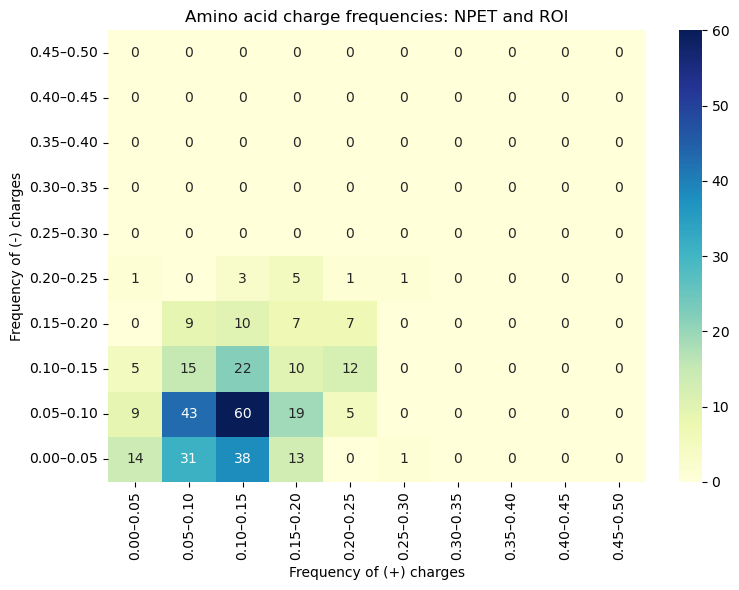

In [41]:
# Create heatmap data
heatmap_data = (
    df_heat.groupby(['neg_bin', 'pos_bin'])
    .size()
    .unstack(fill_value=0)
    .reindex(index=range(bin_count), columns=range(bin_count), fill_value=0)
)

# Create bin labels for plotting
bin_edges = np.linspace(0, freq_max, bin_count + 1)
bin_labels = [f"{bin_edges[i]:.2f}–{bin_edges[i+1]:.2f}" for i in range(bin_count)]
heatmap_data.index = bin_labels  # neg_freq (y-axis)
heatmap_data.columns = bin_labels  # pos_freq (x-axis)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu").invert_yaxis()

# TODO: change title
plt.title(f"Amino acid charge frequencies: NPET and ROI")
plt.xlabel("Frequency of (+) charges")
plt.ylabel("Frequency of (-) charges")
plt.tight_layout()
plt.show()